In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [26]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')
import missingno
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.metrics import accuracy_score

from matplotlib import font_manager, rc
font_path = "/content/drive/MyDrive/L1/Notebooks/dataset/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [27]:
!pwd

/content


In [28]:
ddf = pd.read_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/dataset_for_analysis.pkl')

In [29]:
ddf

,spent_less,cloth_lingerie_purch_diff,cloth_sports_purch_diff,cloth_etc_purch_diff,cloth_business_purch_diff,hobby_media_purch_diff,hobby_pet_purch_diff,hobby_outdoor_purch_diff,hobby_sports_purch_diff,hobby_health_purch_diff,hobby_instex_purch_diff,cloth_women_purch_diff,hobby_golf_purch_diff,A_purch_diff,B_purch_diff,Recency,cloth_highvalue,cloth_lowvalue,cloth_mediumvalue,hobby_highvalue,hobby_lowvalue,hobby_mediumvalue,CLOTH_MEN_PERDAY_VISITING,CLOTH_CASUAL_PERDAY_VISITING,CLOTH_ETC_PERDAY_VISITING,CLOTH_BUSINESS_PERDAY_VISITING,CLOTH_LINGERIE_PERDAY_VISITING,CLOTH_SPORTS_PERDAY_VISITING,CLOTH_WOMEN_PERDAY_VISITING,HOBBY_PET_PERDAY_VISITING,HOBBY_GOLF_PERDAY_VISITING,HOBBY_MEDIA_PERDAY_VISITING,HOBBY_CHILD_PERDAY_VISITING,HOBBY_HEALTH_PERDAY_VISITING,HOBBY_OUTDOOR_PERDAY_VISITING,HOBBY_INSTEX_PERDAY_VISITING,MEMBERSHIP_CAT_2,MEMBERSHIP_CAT_3
0,1,0.000000,0.0,-0.000051,-0.000102,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,-0.000050,0.000000,29,3.0,0.0,0.0,0.0,0.0,0.0,-0.0659,0.1099,-0.0110,0.000,0.0000,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.000,0.000,0,0
1,0,0.001979,0.0,-0.000142,0.000000,0.0,-0.00036,0.000000,0.0,0.0,0.000000,0.0,-0.000468,0.000032,0.000000,2,2.0,0.0,0.0,5.0,2.0,0.0,0.0000,0.0330,-0.0330,0.000,0.0219,0.0,0.0,-0.011,-0.0549,0.0,0.0,0.0,0.000,0.000,0,0
2,1,0.000000,0.0,0.000000,0.000253,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,-0.000075,0.000025,0.000046,9,1.0,0.0,0.0,1.0,0.0,0.0,0.0000,-0.0439,0.0000,0.033,0.0000,0.0,0.0,0.000,-0.0110,0.0,0.0,0.0,0.000,0.000,0,0
3,0,0.000350,0.0,0.000037,-0.000011,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000012,0.000058,0.000050,25,12.0,0.0,4.0,1.0,0.0,0.0,0.0110,0.0879,0.0219,-0.011,0.0659,0.0,0.0,0.000,0.0110,0.0,0.0,0.0,0.000,0.000,0,0
4,0,0.000114,0.0,-0.000813,-0.000187,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,-0.000003,0.000233,0.000000,2,5.0,0.0,0.0,1.0,0.0,0.0,-0.0110,0.0440,-0.0769,-0.022,0.0110,0.0,0.0,0.000,-0.0110,0.0,0.0,0.0,0.000,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16290,0,0.000011,0.0,-0.000010,0.000000,0.0,0.00000,0.000971,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000130,57,0.0,0.0,0.0,3.0,0.0,0.0,0.0000,0.0000,-0.0110,0.000,0.0000,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.033,0.000,0,0
16291,1,0.000000,0.0,0.000000,-0.000083,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,90,1.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,-0.011,0.0000,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.000,0.000,0,1
16292,1,-0.000282,0.0,-0.000065,0.000144,0.0,0.00000,0.000000,0.0,0.0,-0.001073,0.0,0.000000,-0.000046,-0.000079,2,17.0,1.0,7.0,0.0,0.0,1.0,0.0110,-0.1648,-0.0220,0.011,-0.0549,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.000,-0.011,0,0
16293,1,-0.000024,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000003,0.000000,40,2.0,0.0,0.0,0.0,0.0,0.0,0.0000,-0.0110,0.0000,0.000,-0.0110,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.000,0.000,0,0


In [30]:
# label, feature 분리
y = ddf['spent_less']
X = ddf.drop(['spent_less'], axis=1)

In [31]:
# 학습, 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=0) # stratify=y_labels?
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(13036, 37), 테스트 세트 Shape:(3259, 37)
 학습 세트 레이블 값 분포 비율
1    0.54035
0    0.45965
Name: spent_less, dtype: float64

 테스트 세트 레이블 값 분포 비율
1    0.544339
0    0.455661
Name: spent_less, dtype: float64


In [38]:
# LogisticRegression model

from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

In [39]:
# 스케일링
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
# 정규화된 모델 재학습

from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC AUC는 pred 대신 pred_proba
    roc_score=roc_auc_score(y_test,pred_proba) # pred_proba

    print('오차행렬')
    print(confusion)
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, \
    f1 score:{3:.4f}, ROC AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_score))
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차행렬
[[1079  406]
 [ 209 1565]]
정확도:0.8113, 정밀도:0.7940, 재현율:0.8822,     f1 score:0.8358, ROC AUC:0.8968


In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fprs, tprs, thresholds = roc_curve(y_test, lr_pred_proba)
thr_index = np.arange(1, thresholds.shape[0], 5)

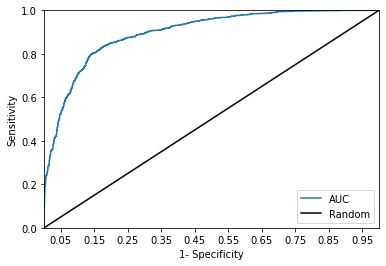

In [43]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임계값에 따른 FPR, TPR값을 반환 받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    # ROC curve를 plot 곡선으로 그림
    plt.plot(fprs, tprs, label = 'AUC')
    
    # 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],'k-', label = 'Random')
    
    # FPR X축의 스케일을 0.1 단위로 변경, X,Y 축 설정
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('1- Specificity'); plt.ylabel('Sensitivity')
    plt.legend()
roc_curve_plot(y_test, lr_pred_proba)


- 하이퍼파라미터 튜닝

In [44]:
from sklearn.model_selection import GridSearchCV

params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2', 'l3', 'l4', 'l5']}

grid_dtree = GridSearchCV(lr_clf, param_grid= params, cv=3, refit=True)
grid_dtree.fit(X_train, y_train)   

print('GCV 최적 하이퍼 파라미터:', grid_dtree.best_params_)   # 최적의 파라미터
print('GCV 최고 정확도:{0:.4f}'.format(grid_dtree.best_score_)) 

# esitimator = grid_dtree.best_estimator_ 
best_dtree = grid_dtree.best_estimator_  # 베스트 params가 적용된 estimator

dtpred = grid_dtree.predict(X_test)
accuracy = accuracy_score(y_test, dtpred) # 실제데이터와 비교 (정확도 확인)
print('DT 정확도:{0:.4f}'.format(accuracy)) 

GCV 최적 하이퍼 파라미터: {'C': 100, 'penalty': 'l2'}
GCV 최고 정확도:0.8288
DT 정확도:0.8110


In [45]:
# LogisticRegression model - 최적 파라미터 값

from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(C =100 ,penalty = 'l2')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차행렬
[[1081  404]
 [ 212 1562]]
정확도:0.8110, 정밀도:0.7945, 재현율:0.8805,     f1 score:0.8353, ROC AUC:0.8976


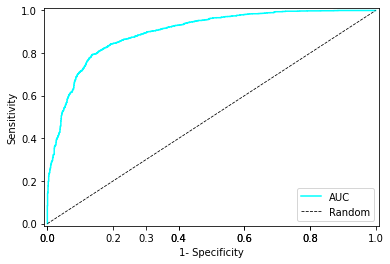

In [46]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임계값에 따른 FPR, TPR값을 반환 받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    # ROC curve를 plot 곡선으로 그림
    plt.plot(fprs, tprs, label = 'AUC',color = 'cyan')
    
    # 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],'k--',linewidth=0.8, label = 'Random')
    
    # FPR X축의 스케일을 0.1 단위로 변경, X,Y 축 설정
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),1))
    plt.xlim(-0.01,1.01); plt.ylim(-0.01,1.01)
    plt.xlabel('1- Specificity'); plt.ylabel('Sensitivity')
    plt.legend()
roc_curve_plot(y_test, lr_pred_proba)

In [47]:
lr_clf.coef_

array([[-2.13477720e-01, -1.13848945e-01, -1.55939049e+00,
        -1.03986714e+00, -3.67893943e-01, -3.60003701e-02,
        -2.06230852e-01, -1.97214416e-02, -6.41243292e-02,
        -9.34461594e-02, -5.45550070e-02, -7.02445871e-01,
        -1.66876537e+01, -8.48957029e-01, -4.75796496e-02,
         2.32404916e-01, -2.97484346e-03, -1.13210567e-01,
        -6.48410215e-02, -4.24090189e-02, -2.79700659e-02,
        -6.29857948e-01, -1.48190110e+00, -2.38241953e-01,
        -1.67221051e-01, -1.63030351e-01, -3.75046784e-02,
         1.40170342e-02, -5.11187301e-02, -1.93176131e-01,
         1.55280084e-02, -2.21770018e-01, -2.47634139e-02,
        -6.69117174e-02,  1.77296548e-02,  1.72046792e-02,
         1.64579790e-02]])

In [48]:

x2 = sm.add_constant(X)
model = sm.OLS(y, x2)
result = model.fit()
print(result.summary2())


                          Results: Ordinary least squares
Model:                     OLS                   Adj. R-squared:          0.243     
Dependent Variable:        spent_less            AIC:                     19047.3022
Date:                      2021-03-09 15:21      BIC:                     19339.8495
No. Observations:          16295                 Log-Likelihood:          -9485.7   
Df Model:                  37                    F-statistic:             142.3     
Df Residuals:              16257                 Prob (F-statistic):      0.00      
R-squared:                 0.245                 Scale:                   0.18800   
------------------------------------------------------------------------------------
                                 Coef.   Std.Err.    t     P>|t|    [0.025   0.975] 
------------------------------------------------------------------------------------
const                             0.5671   0.0068  83.4637 0.0000    0.5537   0.5804
cloth_l

In [52]:

p_value = [
0.6139,
0.7845,
0.000,
0.0036,
0.5621,
0.0046,
0.0000,
0.5397,
0.0204,
0.3247,
0.6537,
0.0000,
0.0061,
0.0030,
0.0075,
0.0000,
0.6178,
0.0121,
0.5170,
0.9355,
0.0008,
0.0000,
0.0000,
0.0000,
0.0000,
0.0000,
0.0000,
0.8516,
0.0016,
0.0000,
0.0002,
0.0000,
0.0964,
0.0000,
0.0875,
0.4033,
0.8361
]
array = [-2.13477720e-01, -1.13848945e-01, -1.55939049e+00,
        -1.03986714e+00, -3.67893943e-01, -3.60003701e-02,
        -2.06230852e-01, -1.97214416e-02, -6.41243292e-02,
        -9.34461594e-02, -5.45550070e-02, -7.02445871e-01,
        -1.66876537e+01, -8.48957029e-01, -4.75796496e-02,
         2.32404916e-01, -2.97484346e-03, -1.13210567e-01,
        -6.48410215e-02, -4.24090189e-02, -2.79700659e-02,
        -6.29857948e-01, -1.48190110e+00, -2.38241953e-01,
        -1.67221051e-01, -1.63030351e-01, -3.75046784e-02,
         1.40170342e-02, -5.11187301e-02, -1.93176131e-01,
         1.55280084e-02, -2.21770018e-01, -2.47634139e-02,
        -6.69117174e-02,  1.77296548e-02,  1.72046792e-02,
         1.64579790e-02]
    

index = ['cloth_lingerie_purch_diff', 'cloth_sports_purch_diff',
       'cloth_etc_purch_diff', 'cloth_business_purch_diff',
       'hobby_media_purch_diff', 'hobby_pet_purch_diff',
       'hobby_outdoor_purch_diff', 'hobby_sports_purch_diff',
       'hobby_health_purch_diff', 'hobby_instex_purch_diff',
       'cloth_women_purch_diff', 'hobby_golf_purch_diff', 'A_purch_diff',
       'B_purch_diff', 'Recency', 'cloth_highvalue', 'cloth_lowvalue',
       'cloth_mediumvalue', 'hobby_highvalue', 'hobby_lowvalue',
       'hobby_mediumvalue', 'CLOTH_MEN_PERDAY_VISITING',
       'CLOTH_CASUAL_PERDAY_VISITING', 'CLOTH_ETC_PERDAY_VISITING',
       'CLOTH_BUSINESS_PERDAY_VISITING', 'CLOTH_LINGERIE_PERDAY_VISITING',
       'CLOTH_SPORTS_PERDAY_VISITING', 'CLOTH_WOMEN_PERDAY_VISITING',
       'HOBBY_PET_PERDAY_VISITING', 'HOBBY_GOLF_PERDAY_VISITING',
       'HOBBY_MEDIA_PERDAY_VISITING', 'HOBBY_CHILD_PERDAY_VISITING',
       'HOBBY_HEALTH_PERDAY_VISITING', 'HOBBY_OUTDOOR_PERDAY_VISITING',
       'HOBBY_INSTEX_PERDAY_VISITING', 'MEMBERSHIP_CAT_2', 'MEMBERSHIP_CAT_3'
]



In [61]:
a = pd.DataFrame(p_value, index = index , columns = {'P > |t|'})
b = pd.DataFrame(array,index = index, columns = ['coef'])

In [65]:
b = pd.DataFrame(array,index = index, columns = ['coef'])
b

,coef
cloth_lingerie_purch_diff,-0.213478
cloth_sports_purch_diff,-0.113849
cloth_etc_purch_diff,-1.559390
cloth_business_purch_diff,-1.039867
hobby_media_purch_diff,-0.367894
hobby_pet_purch_diff,-0.036000
hobby_outdoor_purch_diff,-0.206231
hobby_sports_purch_diff,-0.019721
hobby_health_purch_diff,-0.064124
hobby_instex_purch_diff,-0.093446


In [64]:
c = pd.concat([b,a], axis =1)
c

,coef,P > |t|
cloth_lingerie_purch_diff,-0.213478,0.6139
cloth_sports_purch_diff,-0.113849,0.7845
cloth_etc_purch_diff,-1.559390,0.0000
cloth_business_purch_diff,-1.039867,0.0036
hobby_media_purch_diff,-0.367894,0.5621
hobby_pet_purch_diff,-0.036000,0.0046
hobby_outdoor_purch_diff,-0.206231,0.0000
hobby_sports_purch_diff,-0.019721,0.5397
hobby_health_purch_diff,-0.064124,0.0204
hobby_instex_purch_diff,-0.093446,0.3247
